# Simultaneous plume analysis — EnMAP, GHGSat, EMIT (Buenos Aires, 2024-01-12)

This notebook stitches together the plume analysis workflows for the EnMAP matched-filter outputs (eight MF modes), a single GHGSat product, and a single EMIT product acquired over Buenos Aires on 2024-01-12. It mirrors the original per-satellite notebooks while adding side-by-side mosaics and a recap table summarizing plume areas, IME, and flux uncertainties across all cases.


## 1. Setup
Import the shared geospatial utilities, add the repository root to `sys.path`, and configure a common output folder for any intermediate clips generated during the walkthrough.

In [1]:

import os
import sys
import math
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from osgeo import gdal, ogr
from pyproj import CRS
import geopandas as gpd
import matplotlib.pyplot as plt

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts import plumes_analyzer
from scripts.satellites import enmap_utils

plt.rcParams['figure.dpi'] = 110
OUTPUT_BASE = NOTEBOOK_ROOT / 'outputs' / 'triple_satellite_case'
OUTPUT_BASE.mkdir(parents=True, exist_ok=True)


## 2. Configure the simultaneous acquisitions
Paths point to the three collocated scenes (EnMAP, GHGSat, and EMIT) captured on 2024-01-12 over Buenos Aires. Eight EnMAP matched-filter outputs are inspected: four using the 2100–2450 nm window and four using the 1500–2500 nm window. Wind assumptions are aligned across all satellites for comparability.

In [2]:
BASE_DIR = Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas')
BA_ROOT = BASE_DIR / 'case_studies_data' / 'BuenosAires_20240112'
ENMAP_ROOT = BA_ROOT / 'EnMAP'
ENMAP_L1B_DIR = ENMAP_ROOT 
ENMAP_NARROW_DIR = ENMAP_ROOT / 'MF_narrow'
ENMAP_BROAD_DIR = ENMAP_ROOT / 'MF_broad'
ENMAP_VECTOR = Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/BuenosAires_20240112/ime_com_aoi_exp/ime_com_aoi.shp')

ENMAP_SPECTRAL_ASSETS = {
    'sensor': 'enmap',
    'vnir': ENMAP_L1B_DIR / 'ENMAP01-____L1B-DT0000058121_20240112T144653Z_002_V010501_20241021T060427Z-SPECTRAL_IMAGE_VNIR.TIF',
    'swir': ENMAP_L1B_DIR / 'ENMAP01-____L1B-DT0000058121_20240112T144653Z_002_V010501_20241021T060427Z-SPECTRAL_IMAGE_SWIR.TIF',
    'metadata': ENMAP_L1B_DIR / 'ENMAP01-____L1B-DT0000058121_20240112T144653Z_002_V010501_20241021T060427Z-METADATA.XML',
}

COMMON_WIND = {'u10': 6.7, 'sigma_u10': 1.5}

ENMAP_CASES = [
    {
        'label': 'enmap_2100_srf_k1',
        'scene': 'Buenos Aires (EnMAP, 2100-2450 nm)',
        'mf_mode': 'srf-column',
        'k': 1,
        'window_nm': (2100.0, 2450.0),
        'concentration_file': ENMAP_NARROW_DIR / 'srf_column' / 'k_1' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF_k_1.tif',
        'uncertainty_file': ENMAP_NARROW_DIR / 'srf_column' / 'k_1' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF_uncertainty_k_1.tif',
        'vector_path': ENMAP_VECTOR,
        'unit': 'ppm-m',
        'sensor_type': 'ENMAP',
        'gsd': 30,
        'wind': COMMON_WIND,
        'spectral_assets': ENMAP_SPECTRAL_ASSETS,
        'methane_windows_nm': [(2100.0, 2450.0)],
    },
    {
        'label': 'enmap_2100_srf_k3',
        'scene': 'Buenos Aires (EnMAP, 2100-2450 nm)',
        'mf_mode': 'srf-column',
        'k': 3,
        'window_nm': (2100.0, 2450.0),
        'concentration_file': ENMAP_NARROW_DIR / 'srf_column' / 'k_3' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF_k_3.tif',
        'uncertainty_file': ENMAP_NARROW_DIR / 'srf_column' / 'k_3' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF_uncertainty_k_3.tif',
        'vector_path': ENMAP_VECTOR,
        'unit': 'ppm-m',
        'sensor_type': 'ENMAP',
        'gsd': 30,
        'wind': COMMON_WIND,
        'spectral_assets': ENMAP_SPECTRAL_ASSETS,
        'methane_windows_nm': [(2100.0, 2450.0)],
    },
    {
        'label': 'enmap_2100_full_column',
        'scene': 'Buenos Aires (EnMAP, 2100-2450 nm)',
        'mf_mode': 'full-column',
        'k': None,
        'window_nm': (2100.0, 2450.0),
        'concentration_file': ENMAP_NARROW_DIR / 'full_column' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF_full_co.tif',
        'uncertainty_file': ENMAP_NARROW_DIR / 'full_column' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF_uncertainty_full_co.tif',
        'vector_path': ENMAP_VECTOR,
        'unit': 'ppm-m',
        'sensor_type': 'ENMAP',
        'gsd': 30,
        'wind': COMMON_WIND,
        'spectral_assets': ENMAP_SPECTRAL_ASSETS,
        'methane_windows_nm': [(2100.0, 2450.0)],
    },
    {
        'label': 'enmap_2100_advanced',
        'scene': 'Buenos Aires (EnMAP, 2100-2450 nm)',
        'mf_mode': 'advanced',
        'k': None,
        'window_nm': (2100.0, 2450.0),
        'concentration_file': ENMAP_NARROW_DIR / 'advanced' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF_advanced.tif',
        'uncertainty_file': ENMAP_NARROW_DIR / 'advanced' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF_uncertainty_advanced.tif',
        'vector_path': ENMAP_VECTOR,
        'unit': 'ppm-m',
        'sensor_type': 'ENMAP',
        'gsd': 30,
        'wind': COMMON_WIND,
        'spectral_assets': ENMAP_SPECTRAL_ASSETS,
        'methane_windows_nm': [(2100.0, 2450.0)],
    },
    {
        'label': 'enmap_1500_srf_k1',
        'scene': 'Buenos Aires (EnMAP, 1500-2500 nm)',
        'mf_mode': 'srf-column',
        'k': 1,
        'window_nm': (1500.0, 2500.0),
        'concentration_file': ENMAP_BROAD_DIR / 'srf-column_k1' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_srf-column_k1_MF.tif',
        'uncertainty_file': ENMAP_BROAD_DIR / 'srf-column_k1' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_srf-column_k1_MF_uncertainty.tif',
        'vector_path': ENMAP_VECTOR,
        'unit': 'ppm-m',
        'sensor_type': 'ENMAP',
        'gsd': 30,
        'wind': COMMON_WIND,
        'spectral_assets': ENMAP_SPECTRAL_ASSETS,
        'methane_windows_nm': [(1500.0, 2500.0)],
    },
    {
        'label': 'enmap_1500_srf_k3',
        'scene': 'Buenos Aires (EnMAP, 1500-2500 nm)',
        'mf_mode': 'srf-column',
        'k': 3,
        'window_nm': (1500.0, 2500.0),
        'concentration_file': ENMAP_BROAD_DIR / 'srf-column_k3' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_srf-column_k3_MF.tif',
        'uncertainty_file': ENMAP_BROAD_DIR / 'srf-column_k3' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_srf-column_k3_MF_uncertainty.tif',
        'vector_path': ENMAP_VECTOR,
        'unit': 'ppm-m',
        'sensor_type': 'ENMAP',
        'gsd': 30,
        'wind': COMMON_WIND,
        'spectral_assets': ENMAP_SPECTRAL_ASSETS,
        'methane_windows_nm': [(1500.0, 2500.0)],
    },
    {
        'label': 'enmap_1500_full_column',
        'scene': 'Buenos Aires (EnMAP, 1500-2500 nm)',
        'mf_mode': 'full-column',
        'k': None,
        'window_nm': (1500.0, 2500.0),
        'concentration_file': ENMAP_BROAD_DIR / 'full-column' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_full-column_MF.tif',
        'uncertainty_file': ENMAP_BROAD_DIR / 'full-column' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_full-column_MF_uncertainty.tif',
        'vector_path': ENMAP_VECTOR,
        'unit': 'ppm-m',
        'sensor_type': 'ENMAP',
        'gsd': 30,
        'wind': COMMON_WIND,
        'spectral_assets': ENMAP_SPECTRAL_ASSETS,
        'methane_windows_nm': [(1500.0, 2500.0)],
    },
    {
        'label': 'enmap_1500_advanced',
        'scene': 'Buenos Aires (EnMAP, 1500-2500 nm)',
        'mf_mode': 'advanced',
        'k': 3,
        'window_nm': (1500.0, 2500.0),
        'concentration_file': ENMAP_BROAD_DIR / 'advanced_k3' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_advanced_k3_MF.tif',
        'uncertainty_file': ENMAP_BROAD_DIR / 'advanced_k3' / 'L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_advanced_k3_MF_uncertainty.tif',
        'vector_path': ENMAP_VECTOR,
        'unit': 'ppm-m',
        'sensor_type': 'ENMAP',
        'gsd': 30,
        'wind': COMMON_WIND,
        'spectral_assets': ENMAP_SPECTRAL_ASSETS,
        'methane_windows_nm': [(1500.0, 2500.0)],
    },
]

#“comments out” both advanced variants without touching the rest of the config.
ENMAP_CASES = [case for case in ENMAP_CASES if 'advanced' not in case['label']]


GHGSAT_ROOT = BA_ROOT / 'C6_24034700_20240112_20241008_Qhp5CqH'
GHGSAT_CASE = {
    'label': 'ghgsat_buenosaires',
    'scene': 'Buenos Aires (GHGSat)',
    'sensor_type': 'GHGSAT',
    'unit': 'ppb',
    'concentration_file': GHGSAT_ROOT / 'C6_24034700_20240112_20241008_Qhp5CqH_CH4.tif',
    'uncertainty_file': GHGSAT_ROOT / 'C6_24034700_20240112_20241008_Qhp5CqH_CH4ER.tif',
    'vector_path': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/BuenosAires_20240112/ime_com_aoi_exp/ime_com_aoi.shp'),
    'wind': COMMON_WIND,
    'gsd': None,
}

EMIT_ROOT = BA_ROOT / 'EMIT'
EMIT_CASE = {
    'label': 'emit_buenosaires',
    'scene': 'Buenos Aires (EMIT)',
    'sensor_type': 'EMIT',
    'unit': 'ppm-m',
    'concentration_file': EMIT_ROOT / 'full_dataset' / 'EMITL2BCH4ENH_002' / 'EMIT_L2B_CH4ENH_002_20240112T185917_2401212_016.tif',
    'uncertainty_file': EMIT_ROOT / 'full_dataset' / 'EMITL2BCH4ENH_002' / 'EMIT_L2B_CH4UNCERT_002_20240112T185917_2401212_016.tif',
    'vector_path': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/case_studies_data/BuenosAires_20240112/ime_com_aoi_exp/ime_com_aoi.shp'),
    'wind': COMMON_WIND,
    'gsd': 60,
}

GHGSAT_U_EFF_LOG_COEFF = 0.90
GHGSAT_U_EFF_OFFSET = 0.60

print(f"Configured {len(ENMAP_CASES)} EnMAP cases, plus single GHGSat and EMIT scenes.")


Configured 6 EnMAP cases, plus single GHGSat and EMIT scenes.


## 3. Lightweight reporting helper
`RunReporter` mirrors the per-satellite notebooks: it collects text blocks and figures and can optionally emit a Markdown run log alongside the notebook outputs.

In [3]:
SAVE_RUN_REPORT = True
REPORT_FILE = OUTPUT_BASE / 'plume_analysis_run_report.md'
REPORT_ASSETS_DIR = OUTPUT_BASE / 'assets'

class RunReporter:
    def __init__(self, enabled, report_path, assets_dir, title='Plume Analysis Run Report'):
        self.enabled = bool(enabled)
        self.report_path = Path(report_path) if report_path else None
        self.assets_dir = Path(assets_dir) if assets_dir else None
        self.title = title
        self.sections = []
        if self.enabled and self.assets_dir:
            self.assets_dir.mkdir(parents=True, exist_ok=True)
            self._start_report()

    def _start_report(self):
        if not self.report_path:
            return
        header = f"# {self.title}\n\nGenerated: {datetime.utcnow().isoformat()}Z\n\n"
        self.report_path.write_text(header)

    def log_block(self, title, lines):
        if not self.enabled:
            return
        block = f"\n## {title}\n" + "\n".join(f"- {ln}" for ln in lines) + "\n"
        self.sections.append(block)
        if self.report_path:
            with open(self.report_path, 'a') as f:
                f.write(block)

    def log_figure(self, title, fig):
        if not (self.enabled and self.assets_dir):
            return
        safe = ''.join(ch.lower() if ch.isalnum() else '_' for ch in title).strip('_')
        asset_path = self.assets_dir / f"{safe}.png"
        fig.savefig(asset_path, dpi=150, bbox_inches='tight')
        self.log_block(title, [f"Figure: {asset_path.name}"])

    def save(self):
        if self.enabled and self.report_path:
            print(f"Report saved to {self.report_path}")

reporter = RunReporter(SAVE_RUN_REPORT, REPORT_FILE, REPORT_ASSETS_DIR, title='Buenos Aires multi-sensor plume analysis')

## 4. Helper functions
Utilities to rasterize plume masks, derive background-matched clutter for EnMAP, process each plume polygon, and assemble mosaics and recap tables.

In [4]:

def _rasterize_vector(vector_path, rows, cols, geo_transform, projection):
    vector_ds = ogr.Open(str(vector_path))
    if vector_ds is None:
        raise RuntimeError(f'Failed to open vector file: {vector_path}')
    layer = vector_ds.GetLayer()
    mask_ds = gdal.GetDriverByName('MEM').Create('', cols, rows, 1, gdal.GDT_Byte)
    mask_ds.SetGeoTransform(geo_transform)
    mask_ds.SetProjection(projection)
    gdal.RasterizeLayer(mask_ds, [1], layer, burn_values=[1])
    mask_array = mask_ds.ReadAsArray().astype(bool)
    mask_ds = None
    layer = None
    vector_ds = None
    return mask_array


def _load_spectral_cube(assets):
    cube, wavelengths, _, _, _, _ = enmap_utils.enmap_read(
        str(assets['vnir']), str(assets['swir']), str(assets['metadata'])
    )
    return cube.astype(np.float32), np.asarray(wavelengths, dtype=np.float32)


def _band_mask(wavelengths, windows, guard_nm):
    wav = np.asarray(wavelengths, dtype=float).ravel()
    mask = np.ones_like(wav, dtype=bool)
    for lo, hi in windows:
        mask &= ~((wav >= (lo - guard_nm)) & (wav <= (hi + guard_nm)))
    return mask


def _spectral_distance(cube, ref_mean, ref_std):
    standardized = (cube - ref_mean) / ref_std
    return np.sqrt(np.nanmean(standardized ** 2, axis=2))


def _select_background(distance_map, candidate_mask, percentiles, min_fraction, min_pixels, fallback_percentile=70.0):
    candidate_values = distance_map[candidate_mask]
    if candidate_values.size == 0:
        return candidate_mask & False, None, None
    min_required = max(int(np.ceil(candidate_values.size * min_fraction)), int(min_pixels))
    for perc in percentiles:
        threshold = float(np.nanpercentile(candidate_values, perc))
        mask = (distance_map <= threshold) & candidate_mask
        if mask.sum() >= min_required:
            return mask, threshold, perc
    threshold = float(np.nanpercentile(candidate_values, fallback_percentile))
    mask = (distance_map <= threshold) & candidate_mask
    return mask, threshold, fallback_percentile


def estimate_sigma_surf(
    concentration_ppm_m,
    uncertainty_ppm_m,
    geo_transform,
    projection,
    vector_path,
    spectral_assets,
    methane_windows,
    guard_nm=8.0,
    percentiles=(10, 15, 20, 30, 40, 50),
    min_fraction=0.01,
    min_pixels=750,
):
    concentration = np.asarray(concentration_ppm_m, dtype=np.float32)
    uncertainty = np.asarray(uncertainty_ppm_m, dtype=np.float32)
    finite_mask = np.isfinite(concentration) & np.isfinite(uncertainty)

    plume_mask = _rasterize_vector(vector_path, concentration.shape[0], concentration.shape[1], geo_transform, projection)
    plume_free_mask = (~plume_mask) & finite_mask
    cube, wavelengths = _load_spectral_cube(spectral_assets)
    usable_bands = _band_mask(wavelengths, methane_windows, guard_nm)
    if not np.any(usable_bands):
        raise ValueError('No usable bands remain after masking methane windows.')
    cube = cube[:, :, usable_bands]
    finite_cube = np.all(np.isfinite(cube), axis=2)
    ref_pixels = cube[plume_mask & finite_cube]
    ref_mean = np.nanmedian(ref_pixels, axis=0)
    ref_std = np.nanstd(ref_pixels, axis=0, ddof=1)
    ref_std = np.where(ref_std > 0, ref_std, 1.0)
    distance_map = _spectral_distance(cube, ref_mean, ref_std)
    candidate_mask = plume_free_mask & np.isfinite(distance_map) & finite_cube
    background_mask, threshold, perc = _select_background(distance_map, candidate_mask, percentiles, min_fraction, min_pixels)
    if not np.any(background_mask):
        background_mask = plume_free_mask
    sigma_tot = float(np.nanstd(concentration[background_mask], ddof=1))
    sigma_rmn_sq = float(np.nanmean(np.square(uncertainty[background_mask])))
    sigma_surf = float(np.sqrt(max(0.0, sigma_tot ** 2 - sigma_rmn_sq)))
    info = {
        'background_pixels': int(background_mask.sum()),
        'spectral_percentile': perc,
        'spectral_threshold': threshold,
        'sigma_tot_ppm_m': sigma_tot,
        'sigma_rmn_sq': sigma_rmn_sq,
    }
    return sigma_surf, background_mask, plume_mask, info


def compute_ghgsat_u_eff(u10):
    if u10 <= 0:
        raise ValueError('U10 must be positive for the GHGSat logarithmic U_eff relationship.')
    return GHGSAT_U_EFF_LOG_COEFF * math.log(u10) + GHGSAT_U_EFF_OFFSET


def compute_ghgsat_u_eff_derivative(u10):
    if u10 <= 0:
        raise ValueError('U10 must be positive for the GHGSat logarithmic U_eff derivative.')
    return GHGSAT_U_EFF_LOG_COEFF / u10


def load_case_arrays(concentration_file, uncertainty_file):
    conc_arr, geotransform, projection, _ = plumes_analyzer.load_geotiff(str(concentration_file))
    unc_arr, _, _, _ = plumes_analyzer.load_geotiff(str(uncertainty_file))
    return conc_arr, unc_arr, geotransform, projection


def convert_units(conc_arr, unc_arr, unit):
    conc_clean = plumes_analyzer.discard_neg(conc_arr)
    unc_clean = plumes_analyzer.discard_neg(unc_arr)
    if unit == 'ppm-m':
        return plumes_analyzer.ppm_m_to_ppb(conc_clean), plumes_analyzer.ppm_m_to_ppb(unc_clean)
    return conc_clean, unc_clean


def analyze_case(case_cfg, reporter, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    conc_raw, unc_raw, gt, proj = load_case_arrays(case_cfg['concentration_file'], case_cfg['uncertainty_file'])
    conc_ppb, unc_ppb = convert_units(conc_raw, unc_raw, case_cfg['unit'])
    gsd = case_cfg.get('gsd') or abs(gt[1])
    sigma_surf_ppb = 0.0
    background_info = {}
    plume_mask = None

    if case_cfg['sensor_type'] == 'ENMAP':
        sigma_surf_ppm_m, background_mask, plume_mask, background_info = estimate_sigma_surf(
            conc_raw,
            unc_raw,
            gt,
            proj,
            case_cfg['vector_path'],
            case_cfg['spectral_assets'],
            case_cfg.get('methane_windows_nm', [(1500.0, 1700.0), (2100.0, 2450.0)]),
        )
        sigma_surf_ppb = sigma_surf_ppm_m * 0.125
        reporter.log_block(
            f"{case_cfg['label']} background clutter",
            [
                f"σ_tot: {background_info.get('sigma_tot_ppm_m', np.nan):.4f} ppm·m",
                f"σ_surf: {sigma_surf_ppm_m:.4f} ppm·m ({sigma_surf_ppb:.4f} ppb)",
                f"Background pixels: {background_info.get('background_pixels', 0)}",
            ],
        )

    gdf = gpd.read_file(case_cfg['vector_path'])
    _, _, raster_wkt, _ = plumes_analyzer.load_geotiff(str(case_cfg['concentration_file']))
    raster_crs = CRS.from_wkt(raster_wkt)
    gdf_raster = gdf.to_crs(raster_crs)
    projected_gdf, projected_epsg = plumes_analyzer.project_gdf_to_local_utm(gdf)

    plumes = []
    for idx, (row_raster, row_proj) in enumerate(zip(gdf_raster.itertuples(), projected_gdf.itertuples()), start=1):
        poly = row_raster.geometry
        clip_conc_path = output_dir / f"{case_cfg['label']}_plume{idx}_conc.tif"
        clip_unc_path = output_dir / f"{case_cfg['label']}_plume{idx}_unc.tif"
        clipped_conc = plumes_analyzer.clip_raster_to_polygon(str(case_cfg['concentration_file']), poly, str(clip_conc_path))
        clipped_unc = plumes_analyzer.clip_raster_to_polygon(str(case_cfg['uncertainty_file']), poly, str(clip_unc_path))
        clipped_conc_ppb, clipped_unc_ppb = convert_units(clipped_conc, clipped_unc, case_cfg['unit'])
        clipped_unc_total_ppb = np.sqrt(np.square(clipped_unc_ppb) + sigma_surf_ppb ** 2)
        stats = plumes_analyzer.compute_plume_stats(clipped_conc_ppb)

        area_m2 = row_proj.geometry.area
        pixel_count = int(round(area_m2 / (gsd ** 2)))
        L = math.sqrt(area_m2)
        wind = case_cfg['wind']
        if case_cfg['sensor_type'] == 'GHGSAT':
            u_eff = compute_ghgsat_u_eff(wind['u10'])
            a_coeff = compute_ghgsat_u_eff_derivative(wind['u10'])
        else:
            u_eff, a_coeff, _ = plumes_analyzer.compute_u_eff(wind['u10'], case_cfg['sensor_type'])
        ime = plumes_analyzer.calculate_ime(clipped_conc_ppb, gsd)
        sigma_ime = plumes_analyzer.calculate_sigma_ime(clipped_unc_total_ppb, gsd)
        sigma_ime_instr = plumes_analyzer.calculate_sigma_ime(clipped_unc_ppb, gsd)
        q = plumes_analyzer.compute_flux(ime, u_eff, L)
        sigma_q, sigma_q_ime, sigma_q_wind = plumes_analyzer.propagate_flux_uncertainty(
            q, ime, sigma_ime, wind['u10'], wind['sigma_u10'], u_eff, a_coeff
        )

        plumes.append(
            {
                'plume_id': idx,
                'area_m2': area_m2,
                'pixel_count': pixel_count,
                'L': L,
                'u_eff': u_eff,
                'ime': ime,
                'sigma_ime': sigma_ime,
                'sigma_ime_instr': sigma_ime_instr,
                'q': q,
                'sigma_q': sigma_q,
                'sigma_q_ime': sigma_q_ime,
                'sigma_q_wind': sigma_q_wind,
                'stats': stats,
                'clipped_conc_ppb': clipped_conc_ppb,
                'clipped_unc_ppb': clipped_unc_ppb,
                'clipped_unc_total_ppb': clipped_unc_total_ppb,
            },
        )

        reporter.log_block(
            f"{case_cfg['label']} plume {idx}",
            [
                f"Area: {area_m2:.2f} m^2 (approx {pixel_count} pixels @ {gsd} m)",
                f"IME: {ime:.2f} ± {sigma_ime:.2f} kg",
                f"Flux: {q:.2f} ± {sigma_q:.2f} t/h",
            ],
        )

    return {
        'label': case_cfg['label'],
        'scene': case_cfg['scene'],
        'mf_mode': case_cfg.get('mf_mode'),
        'k': case_cfg.get('k'),
        'window_nm': case_cfg.get('window_nm'),
        'sensor': case_cfg['sensor_type'],
        'unit': case_cfg['unit'],
        'gsd': gsd,
        'wind': case_cfg['wind'],
        'sigma_surf_ppb': sigma_surf_ppb,
        'background_info': background_info,
        'plumes': plumes,
        'concentration_raw': conc_raw,
        'uncertainty_raw': unc_raw,
        'geotransform': gt,
        'projection': proj,
        'vector_path': case_cfg['vector_path'],
        'plume_mask': plume_mask,
    }


def build_recap_table(results):
    rows = []
    for res in results:
        for plume in res['plumes']:
            rows.append(
                {
                    'sensor': res['sensor'],
                    'case': res['label'],
                    'window_nm': res.get('window_nm'),
                    'mf_mode': res.get('mf_mode'),
                    'k': res.get('k'),
                    'plume_id': plume['plume_id'],
                    'pixels': plume['pixel_count'],
                    'area_m2': plume['area_m2'],
                    'IME_kg': plume['ime'],
                    'sigma_IME_kg': plume['sigma_ime'],
                    'Flux_tph': plume['q'],
                    'sigma_Flux_tph': plume['sigma_q'],
                },
            )
    df = pd.DataFrame(rows)
    if not df.empty:
        ordered_cols = ['sensor', 'case', 'window_nm', 'mf_mode', 'k', 'plume_id', 'pixels', 'area_m2', 'IME_kg', 'sigma_IME_kg', 'Flux_tph', 'sigma_Flux_tph']
        df = df[ordered_cols]
    return df


def mosaic_plot(results, key, title, cmap='plasma', vmin=0, vmax=None, cols=3):
    n = len(results)
    cols = min(cols, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.6 * rows))
    axes = np.atleast_2d(axes)
    flat_axes = axes.flat

    # leave space on the right for a dedicated colorbar axis
    fig.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.06, wspace=0.08, hspace=0.08)

    vmax = vmax if vmax is not None else max(float(np.nanmax(res[key])) for res in results)
    for ax, res in zip(flat_axes, results):
        arr = res[key]
        im = ax.imshow(np.ma.masked_invalid(arr), cmap=cmap, vmin=vmin, vmax=vmax)
        label = res['label']
        if res.get('window_nm'):
            lo, hi = res['window_nm']
            label += f"\n{lo:.0f}-{hi:.0f} nm"
        if res.get('mf_mode'):
            label += f" | {res['mf_mode']}"
        if res.get('k'):
            label += f" k={res['k']}"
        ax.set_title(label, fontsize=9)
        ax.axis('off')

    for ax in list(flat_axes)[n:]:
        ax.axis('off')

    # colorbar outside the grid
    cax = fig.add_axes([0.83, 0.15, 0.025, 0.65])
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(title)

    fig.suptitle(title, fontsize=14)
    return fig

## 5. Run the analyses
Loop through the eight EnMAP cases plus the GHGSat and EMIT scenes, compute IME/flux with uncertainties, and keep the full-scene arrays for mosaics.

In [5]:

all_results = []

for cfg in ENMAP_CASES + [GHGSAT_CASE, EMIT_CASE]:
    case_dir = OUTPUT_BASE / cfg['label']
    res = analyze_case(cfg, reporter, case_dir)
    all_results.append(res)
    print(f"Processed {cfg['label']}: {len(res['plumes'])} plume(s)")

reporter.save()


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:9374: RuntimeWarning: the source raster dataset has a SRS, but the cutline features not.  We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


Processed enmap_2100_srf_k1: 1 plume(s)


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:9374: RuntimeWarning: the source raster dataset has a SRS, but the cutline features not.  We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


Processed enmap_2100_srf_k3: 1 plume(s)


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:9374: RuntimeWarning: the source raster dataset has a SRS, but the cutline features not.  We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


Processed enmap_2100_full_column: 1 plume(s)


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:9374: RuntimeWarning: the source raster dataset has a SRS, but the cutline features not.  We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


Processed enmap_1500_srf_k1: 1 plume(s)


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:9374: RuntimeWarning: the source raster dataset has a SRS, but the cutline features not.  We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


Processed enmap_1500_srf_k3: 1 plume(s)


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:9374: RuntimeWarning: the source raster dataset has a SRS, but the cutline features not.  We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


Processed enmap_1500_full_column: 1 plume(s)


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:9374: RuntimeWarning: the source raster dataset has a SRS, but the cutline features not.  We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


Processed ghgsat_buenosaires: 1 plume(s)
Processed emit_buenosaires: 1 plume(s)
Report saved to /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/triple_satellite_case/plume_analysis_run_report.md


/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/osgeo/gdal.py:9374: RuntimeWarning: the source raster dataset has a SRS, but the cutline features not.  We assume that the cutline coordinates are expressed in the destination SRS. If not, cutline results may be incorrect.
  return _gdal.wrapper_GDALWarpDestName(*args)


## 6. Recap table
Areas (pixels and m²), IME with uncertainties, and fluxes with propagated uncertainty for every plume across all cases.

In [6]:

recap_df = build_recap_table(all_results)
recap_df.style.format({
    'area_m2': '{:,.0f}',
    'IME_kg': '{:.2f}',
    'sigma_IME_kg': '{:.2f}',
    'Flux_tph': '{:.2f}',
    'sigma_Flux_tph': '{:.2f}',
}).hide(axis='index')


## 7. Mosaics
Quick-look mosaics of concentration and uncertainty maps. EnMAP cases are shown as an 8-panel grid; GHGSat and EMIT are plotted as side-by-side panels.

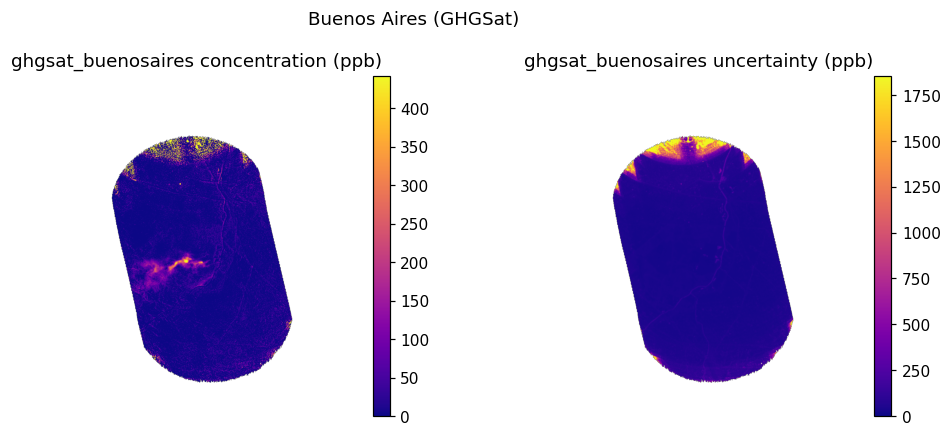

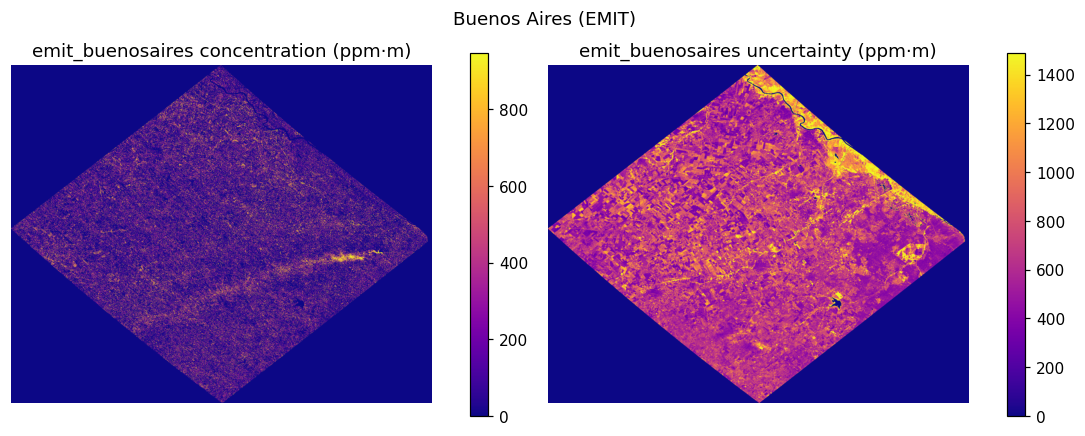

In [7]:
# GHGSat and EMIT side-by-sides
non_enmap = [r for r in all_results if r['sensor'] != 'ENMAP']
for res in non_enmap:
    conc_vmax = float(np.nanpercentile(res['concentration_raw'], 99))
    if not np.isfinite(conc_vmax) or conc_vmax <= 0:
        conc_vmax = float(np.nanmax(res['concentration_raw'])) if np.isfinite(np.nanmax(res['concentration_raw'])) else None
    unc_vmax = float(np.nanpercentile(res['uncertainty_raw'], 99))
    if not np.isfinite(unc_vmax) or unc_vmax <= 0:
        unc_vmax = float(np.nanmax(res['uncertainty_raw'])) if np.isfinite(np.nanmax(res['uncertainty_raw'])) else None
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axes[0].imshow(res['concentration_raw'], cmap='plasma', vmin=0, vmax=conc_vmax)
    axes[0].set_title(f"{res['label']} concentration ({'ppb' if res['unit']=='ppb' else 'ppm·m'})")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.08)
    im1 = axes[1].imshow(res['uncertainty_raw'], cmap='plasma', vmin=0, vmax=unc_vmax)
    axes[1].set_title(f"{res['label']} uncertainty ({'ppb' if res['unit']=='ppb' else 'ppm·m'})")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.08)
    for ax in axes:
        ax.axis('off')
    fig.suptitle(res['scene'], fontsize=12)
    reporter.log_figure(f"{res['label']}_quicklook", fig)
    plt.tight_layout()
    plt.show()

## 8. Segmented plume overlays
Zoomed concentration/uncertainty maps over the segmented plume polygons, with the plume mask outlined.

In [8]:
def _crop_with_padding(mask, pad=6):
    rows, cols = np.where(mask)
    if rows.size == 0:
        return None
    r0 = max(int(rows.min()) - pad, 0)
    r1 = min(int(rows.max()) + pad + 1, mask.shape[0])
    c0 = max(int(cols.min()) - pad, 0)
    c1 = min(int(cols.max()) + pad + 1, mask.shape[1])
    return r0, r1, c0, c1


def _auto_vmax(arr, pct=99.0):
    if arr.size == 0:
        return None
    vmax = float(np.nanpercentile(arr, pct))
    if not np.isfinite(vmax) or vmax <= 0:
        vmax = float(np.nanmax(arr)) if np.isfinite(np.nanmax(arr)) else None
    return vmax if vmax and vmax > 0 else None


def plot_segmented_overlays(results, reporter=None, vmin_conc=0, vmin_unc=0, padding=6, pct=99.0):
    for res in results:
        vector_path = res.get('vector_path')
        mask = res.get('plume_mask')
        if mask is None and vector_path is not None:
            mask = _rasterize_vector(
                vector_path,
                res['concentration_raw'].shape[0],
                res['concentration_raw'].shape[1],
                res['geotransform'],
                res['projection'],
            )
        if mask is None or not np.any(mask):
            continue
        bbox = _crop_with_padding(mask, pad=padding)
        if bbox is None:
            continue
        r0, r1, c0, c1 = bbox
        conc = res['concentration_raw'][r0:r1, c0:c1]
        unc = res['uncertainty_raw'][r0:r1, c0:c1]
        mask_crop = mask[r0:r1, c0:c1]
        conc_vmax = _auto_vmax(conc, pct=pct)
        unc_vmax = _auto_vmax(unc, pct=pct)
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        im0 = axes[0].imshow(np.ma.masked_invalid(conc), cmap='plasma', vmin=vmin_conc, vmax=conc_vmax)
        axes[0].contour(mask_crop, levels=[0.5], colors='cyan', linewidths=1.2)
        axes[0].set_title(f"{res['label']} plume extent (concentration)")
        plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.06)
        im1 = axes[1].imshow(np.ma.masked_invalid(unc), cmap='magma', vmin=vmin_unc, vmax=unc_vmax)
        axes[1].contour(mask_crop, levels=[0.5], colors='cyan', linewidths=1.2)
        axes[1].set_title(f"{res['label']} plume extent (uncertainty)")
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.06)
        for ax in axes:
            ax.axis('off')
        fig.suptitle(res['scene'], fontsize=12)
        if reporter is not None:
            reporter.log_figure(f"{res['label']}_plume_overlay", fig)
        plt.tight_layout()
        plt.show()

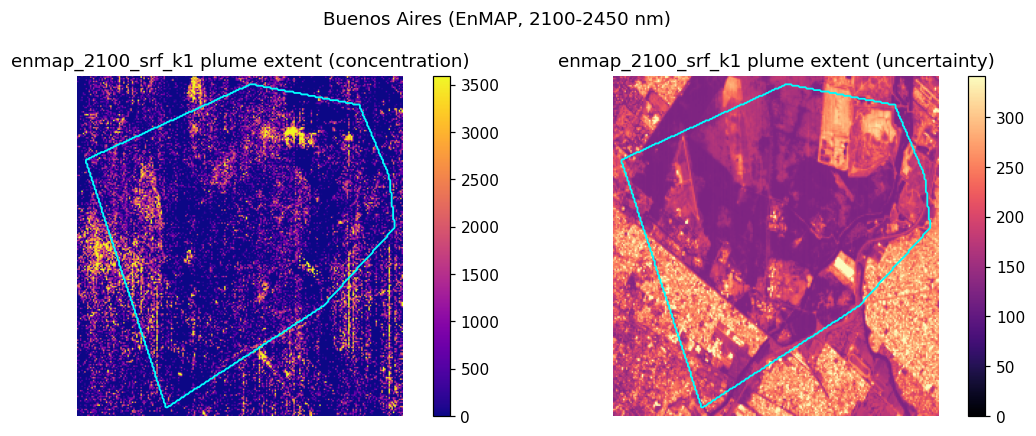

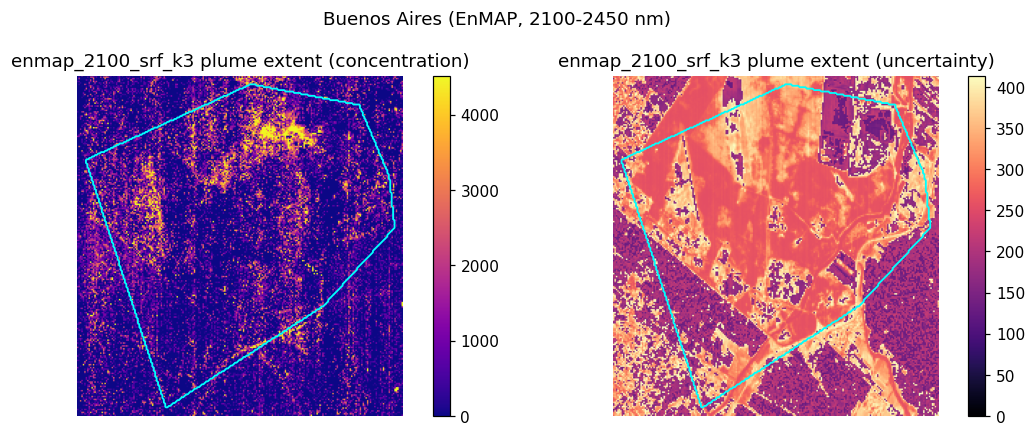

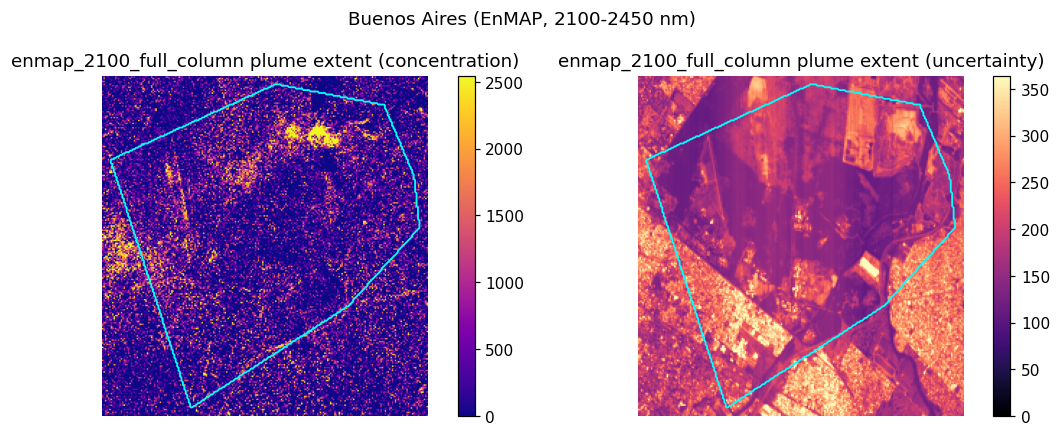

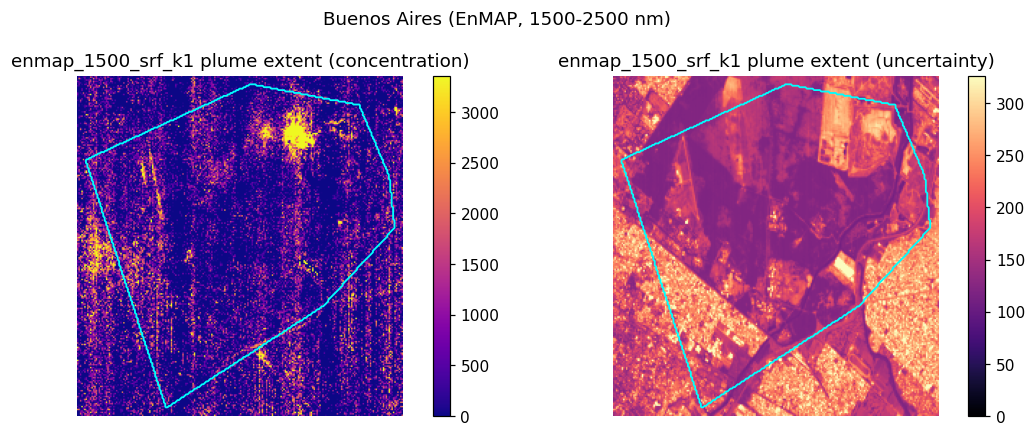

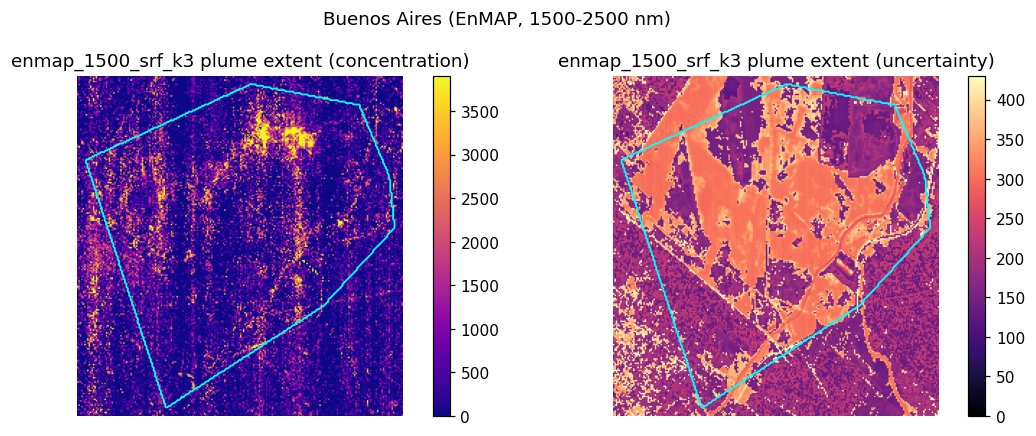

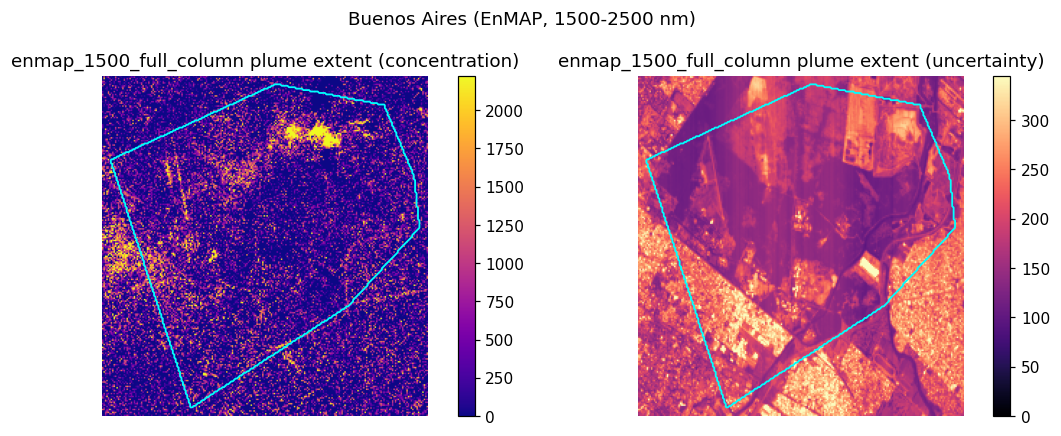

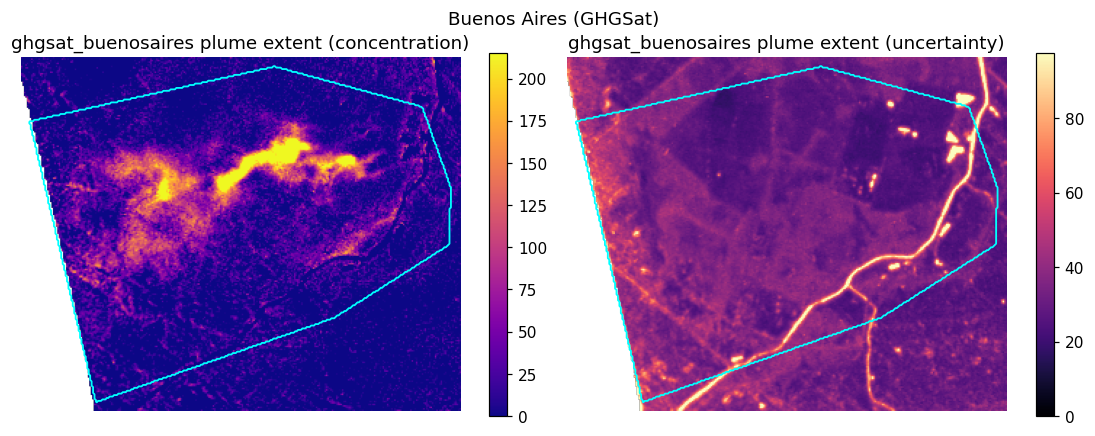

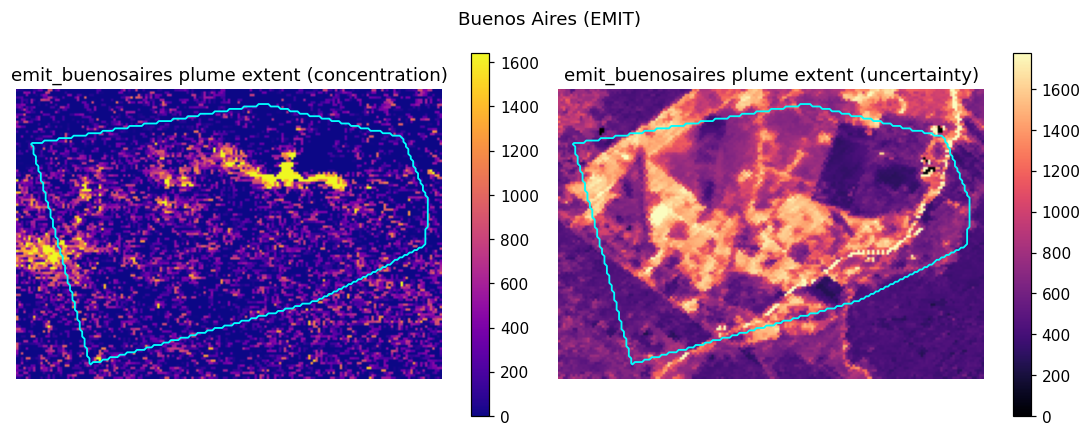

In [9]:
plot_segmented_overlays(all_results, reporter=reporter)